# Topic: Using K-Means Clustering for Heart Disease Analysis

# Description

According to the World Health Organization (WHO), heart disease is the global leading cause of death: 13% of total deaths. Doctors often analyze past cases to enhance their understanding of optimal treatment approaches for their patients. When a patient exhibits similar health history or symptoms to a previous case, they may benefit from undergoing a similar treatment regimen.

This task aims to explore the possibility of grouping patients based on common characteristics using unsupervised learning techniques. Specifically, I will investigate the use of k-means algorithm. By employing this method, we can identify clusters of patients with similar attributes, facilitating targeted treatment strategies.

I will use the "Heart Disease" dataset to train a K-Means clustering model, and try to predict the group of each patient based on their features or symptoms. The number or label of the clusters has not been specified.

# Data Source

The dataset originates from the V.A. Medical Center in Long Beach, California.

# Citation

amirabwd18, Azzedine Idir Aitsaid, Mohcen Chouireb, and Omar Farouk Zouak. K-Means Clustering for Heart Disease Analysis. https://kaggle.com/competitions/kmeans-clustering-for-heart-disease-analysis, 2023. Kaggle.

In [ ]:
from pathlib import Path
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
sns.set_style("whitegrid")

In order to improve readability of the columns of the dataset when we visualize it, we will use a dictionary to rename the columns and a list of categorical columns to preprocess the data.

In [ ]:
# Path to the heart disease dataset file
HEART_DISEASE_FILE_PATH = Path(
    "/kaggle/input/k-means-clustering-for-heart-disease-analysis/heart_disease.csv"
)
HEART_DISEASE_SAMPLE = Path(
    "/kaggle/input/k-means-clustering-for-heart-disease-analysis/sample.csv"
)
# Dictionary to rename columns to improve readability
COLUMNS_DICTIONARY = {
    "sex": "sex",
    "cp": "chest_pain_type",
    "trestbps": "resting_blood_pressure",
    "chol": "cholesterol",
    "fbs": "fasting_blood_sugar",
    "restecg": "resting_electrocardiogram",
    "thalch": "maximum_heart_rate",
    "exang": "exercise_angina",
    "oldpeak": "exercise_st",
    "slope": "slope_st",
    "ca": "n_major_vessels",
    "thal": "thalassemia",
}
CATEGORICAL_COLUMNS = [
    "sex",
    "chest_pain_type",
    "resting_electrocardiogram",
    "slope_st",
    "thalassemia",
]
RANDOM_STATE = 42
CMAP = sns.diverging_palette(230, 20, n=4)

sns.set_palette(CMAP)

## Data Analysis and Preprocessing

I have learnt on the Internet that working with Polars or Pandas would not make a difference when loading this dataset due to the size of the file. However, if we work with larger datasets, Polars is more efficient and faster than Pandas.

I will start by loading the dataset using Polars and then we will perform some basic data analysis.

In [3]:
# Dataframe with heart disease raw data
df_heart = (
    pl.scan_csv(HEART_DISEASE_FILE_PATH)
    .drop(["id", "dataset"])
    .rename(COLUMNS_DICTIONARY)
    .collect()
)

First, check the number of rows in the dataset:

In [4]:
df_heart.shape

(920, 13)

Some of the columns may have null values that are needed to be removed or filled to use the dataset for the k-means clustering.

Let's explore the null values count for each column:

In [5]:
list_columns = df_heart.columns
dtypes = df_heart.dtypes
null_count = df_heart.null_count()
nulls = (
    null_count.transpose()
    .with_columns(
        [
            pl.Series(values=list_columns, name="column_name"),
            pl.Series(values=dtypes, name="dtype"),
        ]
    )
    .rename({"column_0": "null_count"})
    .select(["column_name", "dtype", "null_count"])
    .filter(pl.col("null_count") > 0)
    .with_columns()
    .sort(by=pl.col("null_count"), descending=True)
)
# Get the columns with null values
null_columns = nulls["column_name"].to_list()
nulls

column_name,dtype,null_count
str,object,u32
"""n_major_vessels""",Float64,611
"""thalassemia""",String,486
"""slope_st""",String,309
"""fasting_blood_sugar""",Boolean,90
"""exercise_st""",Float64,62
"""resting_blood_pressure""",Float64,59
"""maximum_heart_rate""",Float64,55
"""exercise_angina""",Boolean,55
"""cholesterol""",Float64,30


The column that has more null values is n_major_vessels. This column has 611 rows with null values. Dropping all these rows would affect the clustering results, since that is 66.41% of the data. The next column is thalassemia with 486 null value rows. 

It is clear that dropping all null values would affect the clustering results, and we need to fill the missing values. 

 Let's visualize these columns to see if we can find a hint to the best strategy:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

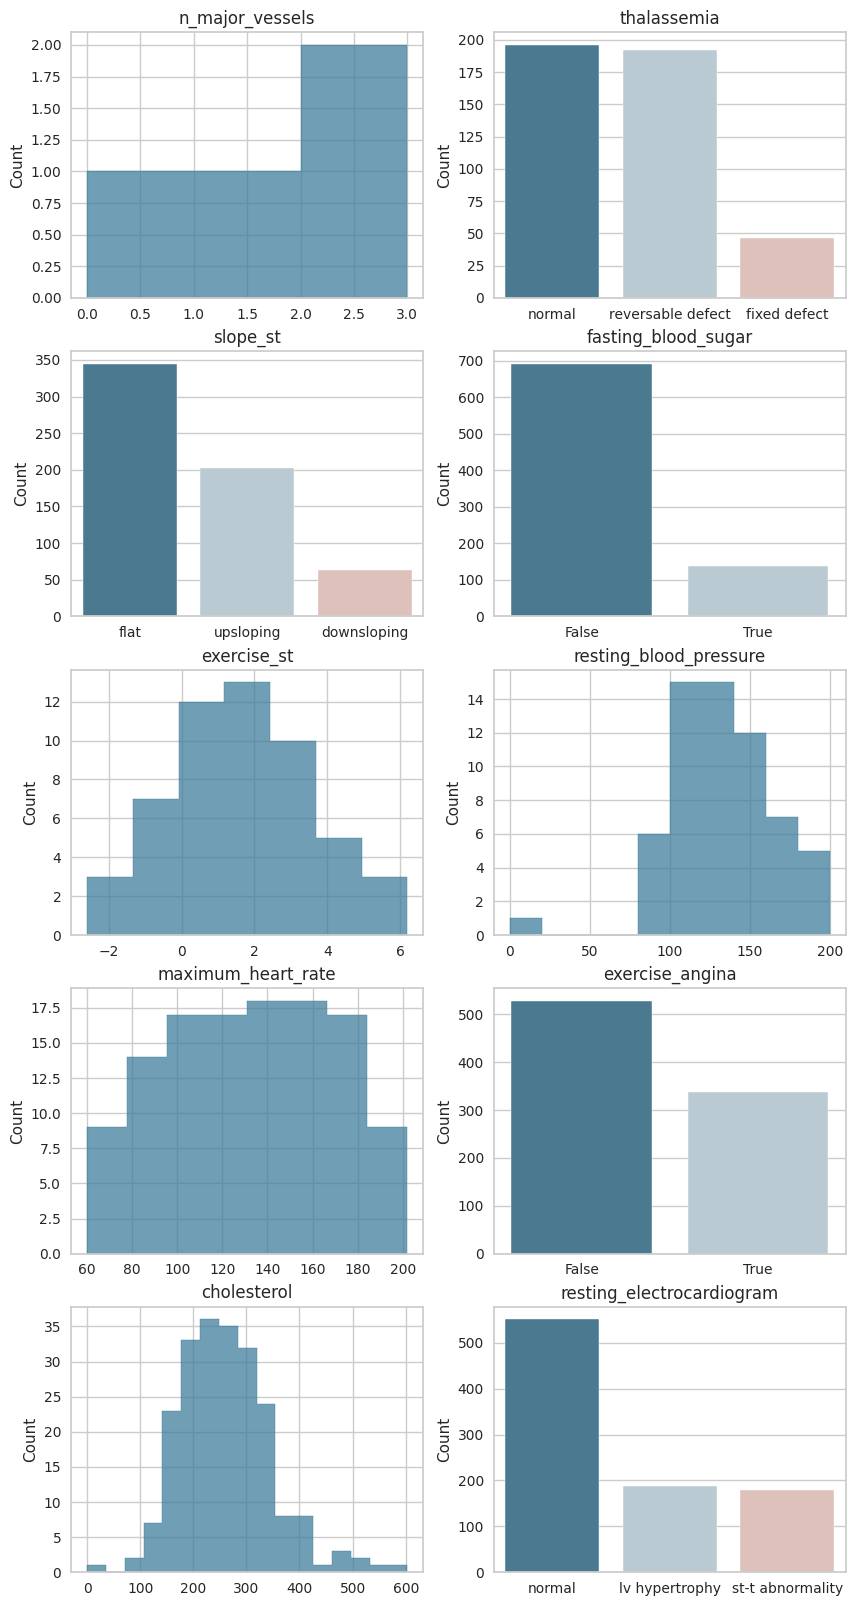

In [6]:
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 20))

pd_heart = df_heart.to_pandas()
for i, name_col in enumerate(null_columns):
    n_col = i % 2
    n_row = i // 2

    counts = pd_heart[name_col].value_counts().reset_index()

    ax[n_row, n_col].set_title(name_col)
    if (
        name_col in CATEGORICAL_COLUMNS
        or name_col == "fasting_blood_sugar"
        or name_col == "exercise_angina"
    ):
        sns.barplot(counts, x=name_col, y="count", ax=ax[n_row, n_col])
    else:
        sns.histplot(counts, x=name_col, ax=ax[n_row, n_col], element="step")
    # ax[n_row, n_col].tick_params(axis='x', rotation=45)
    ax[n_row, n_col].set_ylabel("Count")
    ax[n_row, n_col].set_xlabel("")


plt.show()

We notice that some columns, such as resting_electrocardiogram and fasting_blood_sugar, show clear patterns where the mode frequency significantly outweighs the other categories. However, this is not the case for columns like thalassemia or n_major_vessels. Additionally, for numeric columns, filling missing values with the mode could introduce bias into the dataset.

To simplify the preprocessing of the dataset, we will rely on a combination of visual exploration and dataset documentation. We’ll apply the following rules:

1. n_major_vessels: Since the most frequent value is 0, we will fill missing values with 0.
2. Numeric columns: Missing values will be filled with the mean of the column.
3. All other columns: Missing values will be filled with the most frequent value (the mode).

Let’s now fill the missing values in the dataset according to these rules:


In [7]:
df_heart = (
    df_heart
    .with_columns(
        [
            pl.col("n_major_vessels").cast(pl.Int64),
            pl.col(pl.Boolean).cast(pl.Int64)
        ]
    )
    .with_columns(
        [
            pl.col("n_major_vessels").fill_null(0),
            pl.col(pl.Float64).fill_null(strategy="mean"),
        ]
        +
        [
            # Get the mode without the nulls
            pl.col(col).fill_null(pl.col(col).drop_nulls().mode())
            for col in ["thalassemia", "slope_st", "fasting_blood_sugar", "exercise_angina", "resting_electrocardiogram"]
        ]
    )
)
null_count = df_heart.null_count()
null_count

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,maximum_heart_rate,exercise_angina,exercise_st,slope_st,n_major_vessels,thalassemia
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0


I have already preprocessed the data and ensured that there are no missing values. However, the code is scattered and might be difficult to follow. To address this, we’ll create a class to handle loading, preprocessing, transforming, and visualizing the data.

The class, named HeartDiseaseDataset, will encapsulate these steps and provide the following methods:

1. _get_dataframe: This method retrieves the data from a CSV file and handles preprocessing. This is a standard operation.
2. get_data: This method provides the preprocessed data in the format of a numpy array, polars DataFrame, or pandas DataFrame for convenience.
3. get_ndim_data: This method reduces the dataset’s dimensionality using PCA and returns the reduced data as a numpy array.
4. visualize_data: This method visualizes the dataset using scatter plots.

In [ ]:
class HeartDiseaseDataset:
    def __init__(
        self,
        data_path: Path = HEART_DISEASE_FILE_PATH,
        ids: list[int] = [],
        classes: dict[dict[int, str]] = {},
    ):
        self.data_path = data_path
        self.classes = classes
        self.ids = ids

        self.dataframe = self._get_dataframe()

    def _get_dataframe(self) -> pl.DataFrame:
        dataframe = pl.scan_csv(HEART_DISEASE_FILE_PATH)

        # Filters the dataframe by the ids if provided
        if self.ids:
            dataframe = dataframe.filter(pl.col("id").is_in(self.ids))

        dataframe = (
            dataframe
            # drop the id and dataset columns
            .drop(["id", "dataset"])
            .rename(COLUMNS_DICTIONARY)
            # Cast the `n_major_vessels` column to int
            .with_columns(
                [pl.col("n_major_vessels").cast(pl.Int64)]
                + [pl.col(pl.Boolean).cast(pl.Int64)]
            )
            .with_columns(
                # Fill the float columns with the mean
                [
                    pl.col("n_major_vessels").fill_null(0),
                    pl.col(pl.Float64).fill_null(strategy="mean"),
                ]
                +
                # Fill the categorical columns with the mode without the nulls
                [
                    # Get the mode without the nulls
                    pl.col(col).fill_null(pl.col(col).drop_nulls().mode())
                    for col in [
                        "thalassemia",
                        "slope_st",
                        "fasting_blood_sugar",
                        "exercise_angina",
                        "resting_electrocardiogram",
                    ]
                ]
            )
        )

        # Map the categorical columns to their corresponding labels
        # if classes are provided, else map them using the LabelEncoder
        if self.classes:
            dataframe = dataframe.with_columns(
                pl.col(col).map_elements(
                    lambda x: self.classes[col][x]
                )
                for col in CATEGORICAL_COLUMNS
            )
        else:
            dataframe = dataframe.with_columns(
                pl.col(col).map_batches(lambda col: self._encode_categories(col))
                for col in CATEGORICAL_COLUMNS
            )

        # Cast all the columns to float64
        dataframe = dataframe.collect()
        return dataframe

    def get_data(self, type: str = "numpy") -> np.ndarray | pl.DataFrame | pd.DataFrame:
        if type == "numpy":
            return self.dataframe.to_numpy()
        elif type == "polars":
            return self.dataframe
        elif type == "pandas":
            return self.dataframe.to_pandas()
        else:
            raise ValueError("Invalid type. Must be 'polars', 'numpy', or 'pandas'.")

    def _encode_categories(self, column: pl.Series) -> pl.Series:
        encoder = LabelEncoder()
        new_col = encoder.fit_transform(column.to_numpy())
        self.classes |= {
            column.name: {label: i for i, label in enumerate(encoder.classes_)}
        }
        return pl.Series(new_col, dtype=pl.Int64).alias(column.name)

    def get_ndim_data(self) -> np.ndarray:
        data = self.get_data()
        pca = PCA(n_components=2)
        return pca.fit_transform(data)

    def visualize_data(self):
        ndim_data = self.get_ndim_data()
        plt.figure(figsize=(10, 10))
        sns.scatterplot(x=ndim_data[:, 0], y=ndim_data[:, 1], palette=CMAP)
        plt.xlabel("First Principal Component")
        plt.ylabel("Second Principal Component")
        plt.show()

Visualizing 13 dimensions is not possible, and we need to reduce the dimensionality of the dataset. We use the PCA class from scikit-learn to do this. 

Let's visualize the dataset reduced to 2 dimensions:

/tmp/ipykernel_18/1315150979.py:139: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=ndim_data[:, 0], y=ndim_data[:, 1], palette=CMAP)


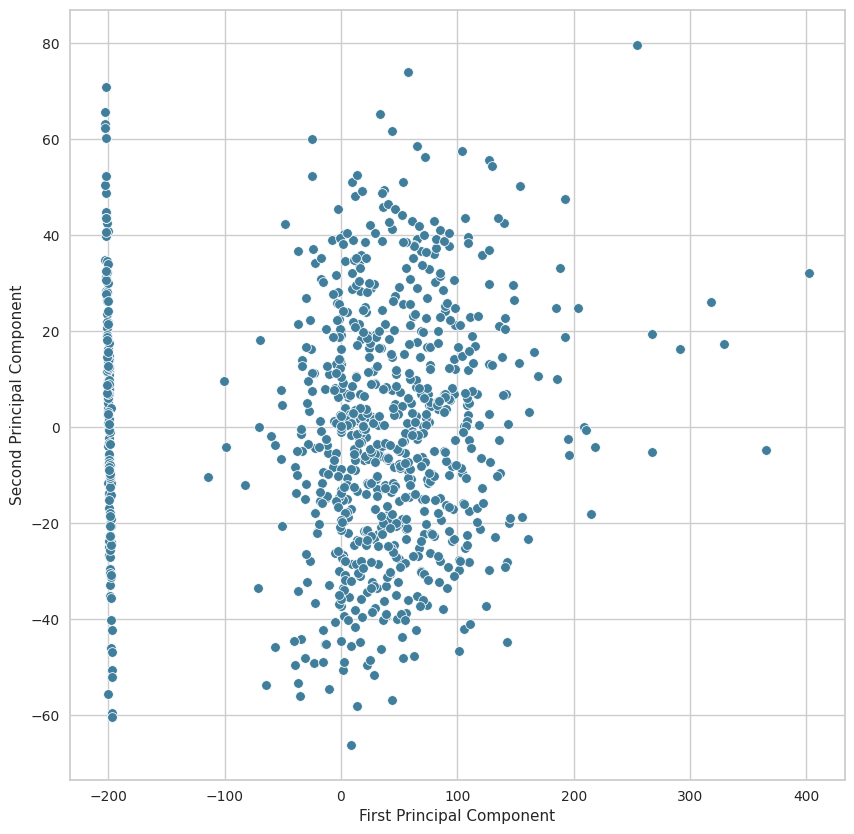

In [9]:
heart_dataset = HeartDiseaseDataset()
heart_dataset.visualize_data()

We can clearly see two groups that are linearly separable. This is a dimensionally reduced dataset, and the original dataset has 13 dimensions. So, making any assumption about the linear separability of the two groups may not be accurate at this point.

## Finding the K in elbow method

When dealing with unsupervised learning problems, selecting appropriate metrics to evaluate model performance can be challenging.
The elbow method is a visual approach used to determine the optimal number of clusters. It involves plotting the distortion score against the number of clusters. The distortion score, often measured as the within-cluster sum of squares (WCSS), assesses how closely data points within each cluster are grouped around their respective centroids.

In [10]:
# Get the data as numpy array
np_heart_dataset = heart_dataset.get_data()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

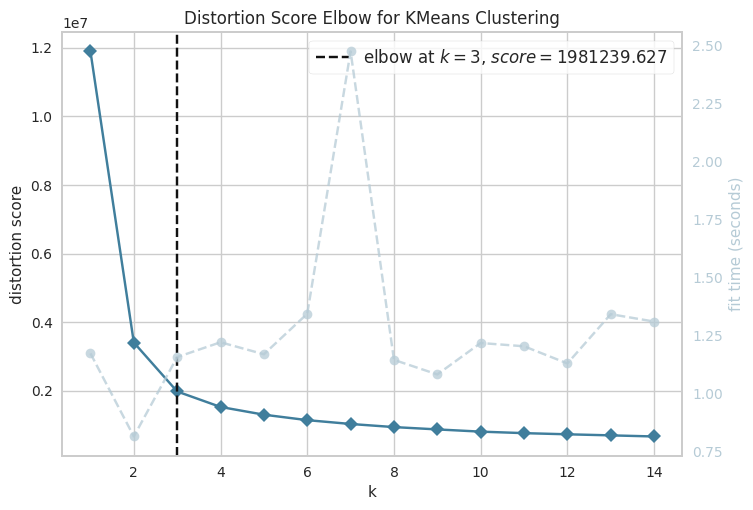

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
model = KMeans(random_state=RANDOM_STATE)
k_elbow = KElbowVisualizer(model, k=(1, 15))
k_elbow.fit(np_heart_dataset)
k_elbow.show()

It looks like the k suggested by the elbow method is 3. Maybe choosing k=2 may be a better choice.

Let's visualize the Silhouette Scores for $k=2$ and $k=3$:


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.7031


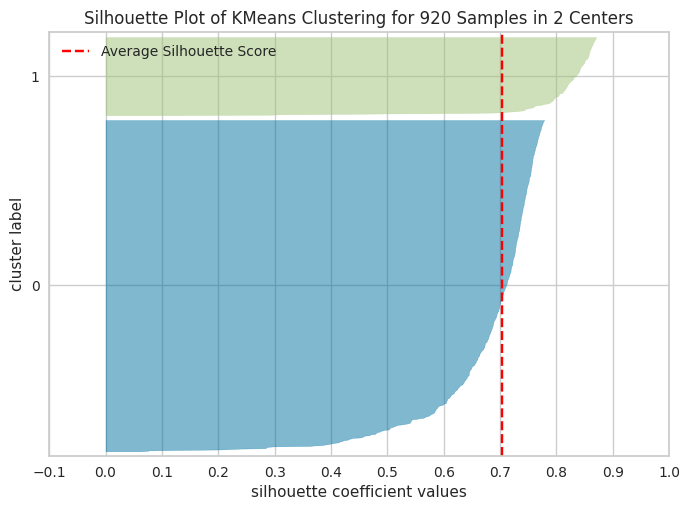

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 920 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [12]:
kmeans_2 = KMeans(n_clusters=2, random_state=RANDOM_STATE)
silhouette_2 = SilhouetteVisualizer(kmeans_2, colors="yellowbrick")
silhouette_2.fit(np_heart_dataset)
score = silhouette_2.silhouette_score_
print(f"Silhouette Score: {score:.4f}")
silhouette_2.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.4770


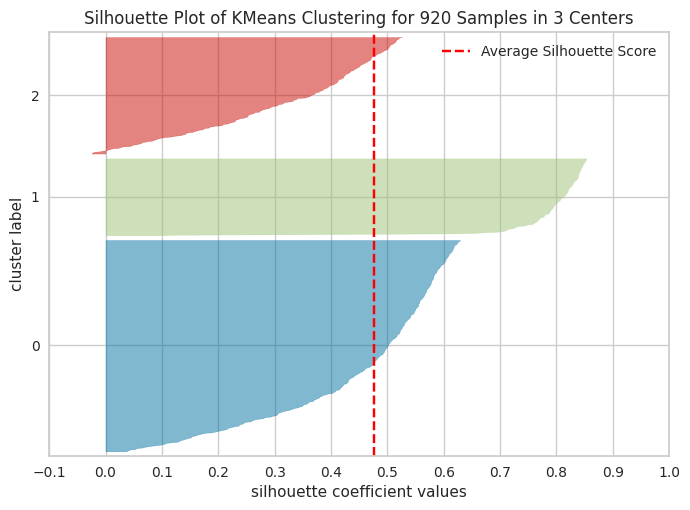

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 920 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [13]:
kmeans_3 = KMeans(n_clusters=3, random_state=RANDOM_STATE) 
silhouette_3 = SilhouetteVisualizer(kmeans_3, colors="yellowbrick")
silhouette_3.fit(np_heart_dataset)
score = silhouette_3.silhouette_score_
print(f"Silhouette Score: {score:.4f}")
silhouette_3.show()

After reviewing the silhouette scores, we can conclude that the best number for k is 2. The silhouette score is higher for k=2 than for k=3, meaning that the data points are better fitted into the clusters with k=2.

## Training

I will train the model at a maximum of 1000 iterations or until the model converges.

In [14]:
# Train the model using 3 clusters
model = KMeans(max_iter=1000, n_clusters=2, random_state=RANDOM_STATE)
model.fit(np_heart_dataset)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=1000, n_clusters=2, random_state=1506)

The predict method of the KMeans class allows us to make predictions. It takes the dataset as input and outputs the cluster assignments for each data point.

Furthermore, we can visualize the dimensionally reduced dataset with the assigned clusters to confirm our hypothesis about the linear separability of the data.

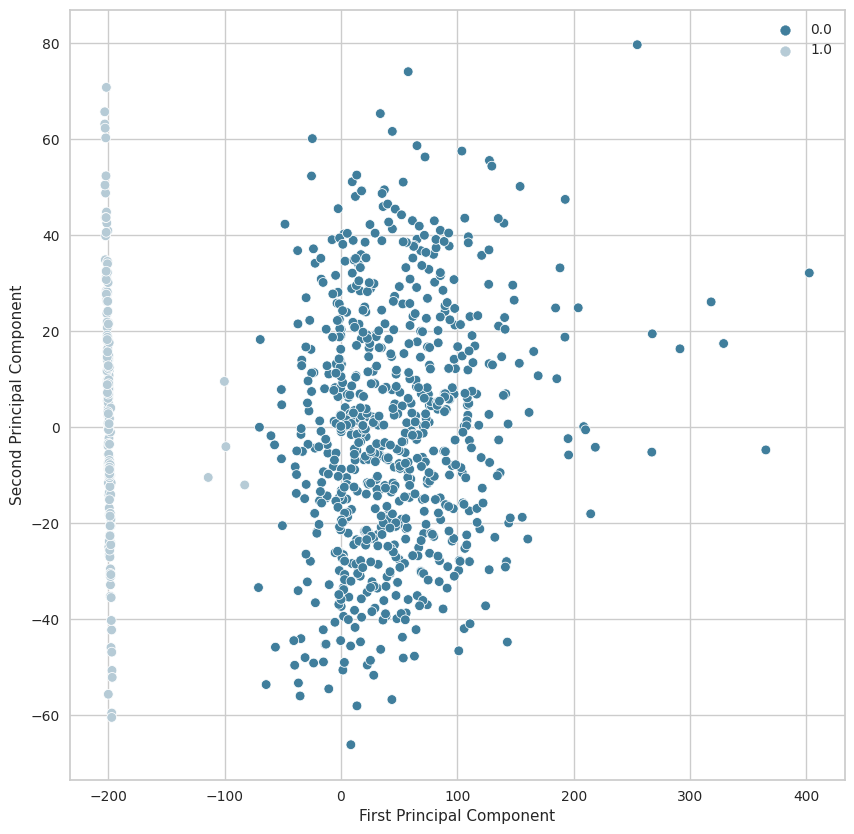

In [15]:
# Make predictions using the model 
preds = model.predict(np_heart_dataset)
heart_dataset_2d = heart_dataset.get_ndim_data()
predictions = np.append(heart_dataset_2d, preds[:, None], axis=1) 

# Visualize the predictions
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=predictions[:, 0], y=predictions[:, 1], hue=predictions[:, 2])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

## Submission

Finally, we can use the predictions made to export the results to a CSV file to submit.

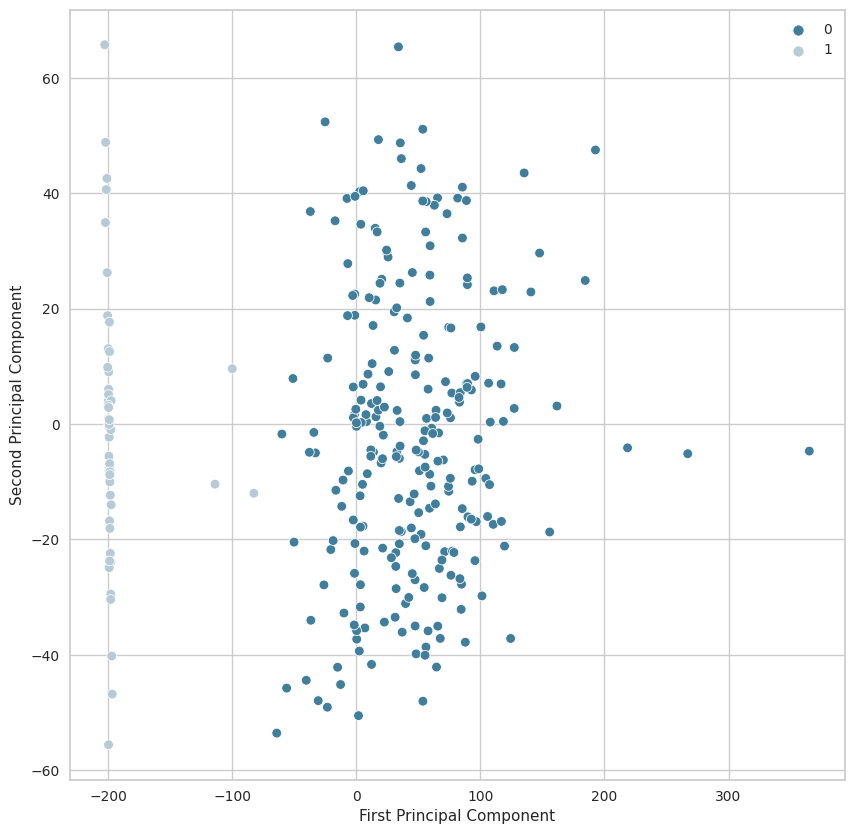

In [16]:
sample_ids = pl.read_csv(HEART_DISEASE_SAMPLE).get_column("id").to_numpy()
sample_preds = [preds[i] for i in sample_ids]
sample_2d_data = heart_dataset_2d[sample_ids]

plt.figure(figsize=(10, 10))
sns.scatterplot(x=sample_2d_data[:, 0], y=sample_2d_data[:, 1], hue=sample_preds)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()



In [17]:
pl.DataFrame({"id": sample_ids, "cluster": sample_preds}).write_csv("submission.csv")

## Conclusions:

The work I have done provided a comprehensive walkthrough of clustering a medical dataset using the K-Means algorithm. I started by addressing common challenges in preprocessing medical data, including handling missing values, encoding categorical columns, and preparing the dataset for clustering. Through a combination of statistical analysis and visual exploration, I made informed decisions about data preparation.

By leveraging dimensionality reduction techniques, we can visualize the clusters effectively and validate assumptions about linear separability.

Finally, I trained a K-Means model, evaluated its performance, and get a good score. 

If I have more computation resource in the future, I may try more iterations in model training, and the result may be better.

